# The `opencadd.structure.subpockets` module

Let's walk through the functionalities offered in the `opencadd.structure.subpockets` module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import time

from bravado.client import SwaggerClient
import pandas as pd

from opencadd.structure.subpockets.parser import Mol2ToDataFrame
from opencadd.structure.subpockets.core import Pocket, Subpocket, Region, AnchorResidue

## Get example protein structure and pocket residues

__Download protein structure file__

First of all, we download structural data for an example protein kinase with PDB ID `4wsq` alternate model A and chain A from the KLIFS database:

https://klifs.vu-compmedchem.nl/details.php?structure_id=3834

In [3]:
KLIFS_API_DEFINITIONS = "http://klifs.vu-compmedchem.nl/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

In [4]:
result = KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=3834).response().result

with open("protein.mol2", "w") as f:
    f.write(result)

At the end of this notebook, we will delete this file again.

__Load protein structure as `DataFrame`__

In [5]:
parser = Mol2ToDataFrame()
protein_df = parser.from_file("protein.mol2")
protein_df.head()

atom.id atom.name   atom.x  atom.y   atom.z atom.type  residue.subst_id  \
0        1         N  10.2784  4.1662  49.9484       N.4                 1   
1        2        H1  10.2440  3.1868  50.1927         H                 1   
2        3        H2   9.9911  4.2838  48.9873         H                 1   
3        4        H3   9.6568  4.6858  50.5515         H                 1   
4        5        CA  11.6355  4.6586  50.1118       C.3                 1   

  residue.subst_name  atom.charge atom.backbone residue.name residue.pdb_id  
0              GLY29          1.0      BACKBONE          GLY             29  
1              GLY29          0.0      BACKBONE          GLY             29  
2              GLY29          0.0      BACKBONE          GLY             29  
3              GLY29          0.0      BACKBONE          GLY             29  
4              GLY29          0.0      BACKBONE          GLY             29

__Get pocket residues__



In [6]:
result = KLIFS_CLIENT.Interactions.get_interactions_match_residues(structure_ID=3834).response().result
pocket_residues = pd.DataFrame(result)
pocket_residues.head()

index Xray_position KLIFS_position
0      1            50            I.1
1      2            51            I.2
2      3            52            I.3
3      4            53          g.l.4
4      5            54          g.l.5

In [7]:
pocket_residue_pdb_ids = pocket_residues["Xray_position"].to_list()
pocket_residue_labels = pocket_residues["index"].to_list()

## Pocket (`Pocket` class)

The `Pocket` class currently holds the following attributes/properties:

- `data`: `DataFrame` containing the structural data of the full protein or the pocket
- `name`: Protein/pocket name
- `residue_pdb_ids`: Pocket residue IDs
- `residue_labels`: Pocket residue labels
- `centroid`: Centroids of all pocket residues' CA atoms
- `subpockets`: Subpockets defined based on a set of anchor residues each
- `regions`: User-defined regions that are of importance for the protein/pocket

### Initialize pocket

We initialize the pocket with the following parameters:
- Protein structure data
- Protein/pocket name
- Pocket residues PDB IDs
- Pocket residue labels (optionally), e.g. for the pocket alignment IDs

In [8]:
pocket = Pocket(
    data=protein_df, 
    name="example kinase", 
    residue_pdb_ids=pocket_residue_pdb_ids, 
    residue_labels=pocket_residue_labels
)

The pocket centroid is calculated based on 85 CA atoms.


Note: If residue PDB IDs and labels do not match in length, a `ValueError` will be thrown.

In [9]:
try: 
    Pocket(protein_df, "example kinase", [1, 2, 3], [1, 2])
except ValueError as e:
    print(e)

Number of residue PDB IDs and labels must be of same length.


Let's take a look at the `Pocket` class attributes/properties after initialization.

__Pocket name__

In [10]:
pocket.name

'example kinase'

__Protein structure data__

In [11]:
pocket.data.head()

atom.id atom.name   atom.x  atom.y   atom.z atom.type  residue.subst_id  \
0        1         N  10.2784  4.1662  49.9484       N.4                 1   
1        2        H1  10.2440  3.1868  50.1927         H                 1   
2        3        H2   9.9911  4.2838  48.9873         H                 1   
3        4        H3   9.6568  4.6858  50.5515         H                 1   
4        5        CA  11.6355  4.6586  50.1118       C.3                 1   

  residue.subst_name  atom.charge atom.backbone residue.name residue.pdb_id  
0              GLY29          1.0      BACKBONE          GLY             29  
1              GLY29          0.0      BACKBONE          GLY             29  
2              GLY29          0.0      BACKBONE          GLY             29  
3              GLY29          0.0      BACKBONE          GLY             29  
4              GLY29          0.0      BACKBONE          GLY             29

__Pocket residues__

In [12]:
pocket.residues.head()

residue.pdb_id residue.labels
0             50              1
1             51              2
2             52              3
3             53              4
4             54              5

__Pocket centroids__

In [13]:
pocket.centroid

array([ 1.13481647, 20.79171176, 36.30449647])

__Subpockets and regions__

We have not set any subpockets or regions (`None`), yet:

In [14]:
pocket.subpockets

In [15]:
pocket.regions

### Add subpockets

Next, we can add subpockets one-by-one to the pocket. For each subpocket we define the following:
- Subpocket __name__, 
- Subpocket __color__, 
- __Residue PDB IDs__ of all __anchor residues__, i.e. the residues determining the subpocket center (centroid of all anchor residues' CA atoms) and 
- __Residue labels__ for all __anchor residues__ (optionally), e.g. if we want to pass an alignment ID to each residue.

The class method `add_subpocket` uses the `Subpocket` class to set up subpockets.

In [16]:
pocket.add_subpocket("hinge_region", "magenta", [73, 128, 193], [16, 47, 80])
pocket.add_subpocket("dfg_region", "cornflowerblue", [76, 90, 194], [19, 24, 81])
pocket.add_subpocket("front_pocket", "cyan", [55, 129, 181], [6, 48, 75])

Using the `Pocket`'s property `subpockets`, we get an overview of all specified subpockets.

In [17]:
pocket.subpockets

subpocket.name subpocket.color_name  \
0   hinge_region              magenta   
1     dfg_region       cornflowerblue   
2   front_pocket                 cyan   

                                 subpocket.color_rgb  \
0                                    (1.0, 0.0, 1.0)   
1  (0.39215686274509803, 0.5843137254901961, 0.92...   
2                                    (0.0, 1.0, 1.0)   

                                    subpocket.center  
0  [1.9576333333333336, 21.923766666666666, 41.69...  
1              [7.613366666666667, 20.0352, 33.4246]  
2  [-0.5543666666666666, 15.943933333333334, 39.5...

Using the `Pocket`'s property `anchor_residues`, we get an overview of all subpockets' anchor residues.

In [18]:
pocket.anchor_residues

subpocket.name subpocket.color_name  \
0   hinge_region              magenta   
1   hinge_region              magenta   
2   hinge_region              magenta   
0     dfg_region       cornflowerblue   
1     dfg_region       cornflowerblue   
2     dfg_region       cornflowerblue   
0   front_pocket                 cyan   
1   front_pocket                 cyan   
2   front_pocket                 cyan   

                                 subpocket.color_rgb anchor_residue.pdb_id  \
0                                    (1.0, 0.0, 1.0)                    73   
1                                    (1.0, 0.0, 1.0)                   128   
2                                    (1.0, 0.0, 1.0)                   193   
0  (0.39215686274509803, 0.5843137254901961, 0.92...                    76   
1  (0.39215686274509803, 0.5843137254901961, 0.92...                    90   
2  (0.39215686274509803, 0.5843137254901961, 0.92...                   194   
0                                    (0.0, 1.0, 1.0)                    55   
1                                    (0.0, 1.0, 1.0)                   129   
2                                    (0.0, 1.0, 1.0)                   181   

  anchor_residue.pdb_id_alternative anchor_residue.label  \
0                              None                   16   
1                              None                   47   
2                              None                   80   
0                              None                   19   
1                              None                   24   
2                              None                   81   
0                              None                    6   
1                              None                   48   
2                              None                   75   

         anchor_residue.center  
0    [7.675, 21.5254, 43.5183]  
1  [-0.3245, 23.4828, 45.9722]  
2  [-1.4776, 20.7631, 35.5796]  
0  [13.7391, 16.4906, 37.1612]  
1   [7.5673, 24.3155, 29.4688]  
2   [1.5337, 19.2995, 33.6438]  
0   [5.5627, 10.2881, 37.6314]  
1  [-3.6779, 21.6755, 45.6664]  
2  [-3.5479, 15.8682, 35.3866]

### Add regions

The `Pocket` class also allows to specify pocket regions, normally used to store key regions, such as the hinge region or the catalytic loop in kinases. This information can be used for pocket visualization.

The class method `add_regions` uses the `Regions` class to set up regions.

In [19]:
pocket.add_region("hinge", "magenta", [127, 128, 129], [46, 47, 48])
pocket.add_region("linker", "cyan", [130, 131, 132, 133], [49, 50, 51, 52])
pocket.add_region("xDFG", "cornflowerblue", [193, 194, 195, 196], [80, 81, 82, 83])

In [20]:
pocket.regions

region.name region.color_name  \
0       hinge           magenta   
1       hinge           magenta   
2       hinge           magenta   
0      linker              cyan   
1      linker              cyan   
2      linker              cyan   
3      linker              cyan   
0        xDFG    cornflowerblue   
1        xDFG    cornflowerblue   
2        xDFG    cornflowerblue   
3        xDFG    cornflowerblue   

                                    region.color_rgb residue.pdb_id  \
0                                    (1.0, 0.0, 1.0)            127   
1                                    (1.0, 0.0, 1.0)            128   
2                                    (1.0, 0.0, 1.0)            129   
0                                    (0.0, 1.0, 1.0)            130   
1                                    (0.0, 1.0, 1.0)            131   
2                                    (0.0, 1.0, 1.0)            132   
3                                    (0.0, 1.0, 1.0)            133   
0  (0.39215686274509803, 0.5843137254901961, 0.92...            193   
1  (0.39215686274509803, 0.5843137254901961, 0.92...            194   
2  (0.39215686274509803, 0.5843137254901961, 0.92...            195   
3  (0.39215686274509803, 0.5843137254901961, 0.92...            196   

  residue.label  
0            46  
1            47  
2            48  
0            49  
1            50  
2            51  
3            52  
0            80  
1            81  
2            82  
3            83

### Visualize pocket

In [22]:
view = pocket.visualize("protein.mol2")
view

NGLWidget()

In [23]:
time.sleep(5)

In [24]:
view.render_image(),

(Image(value=b'', width='99%'),)

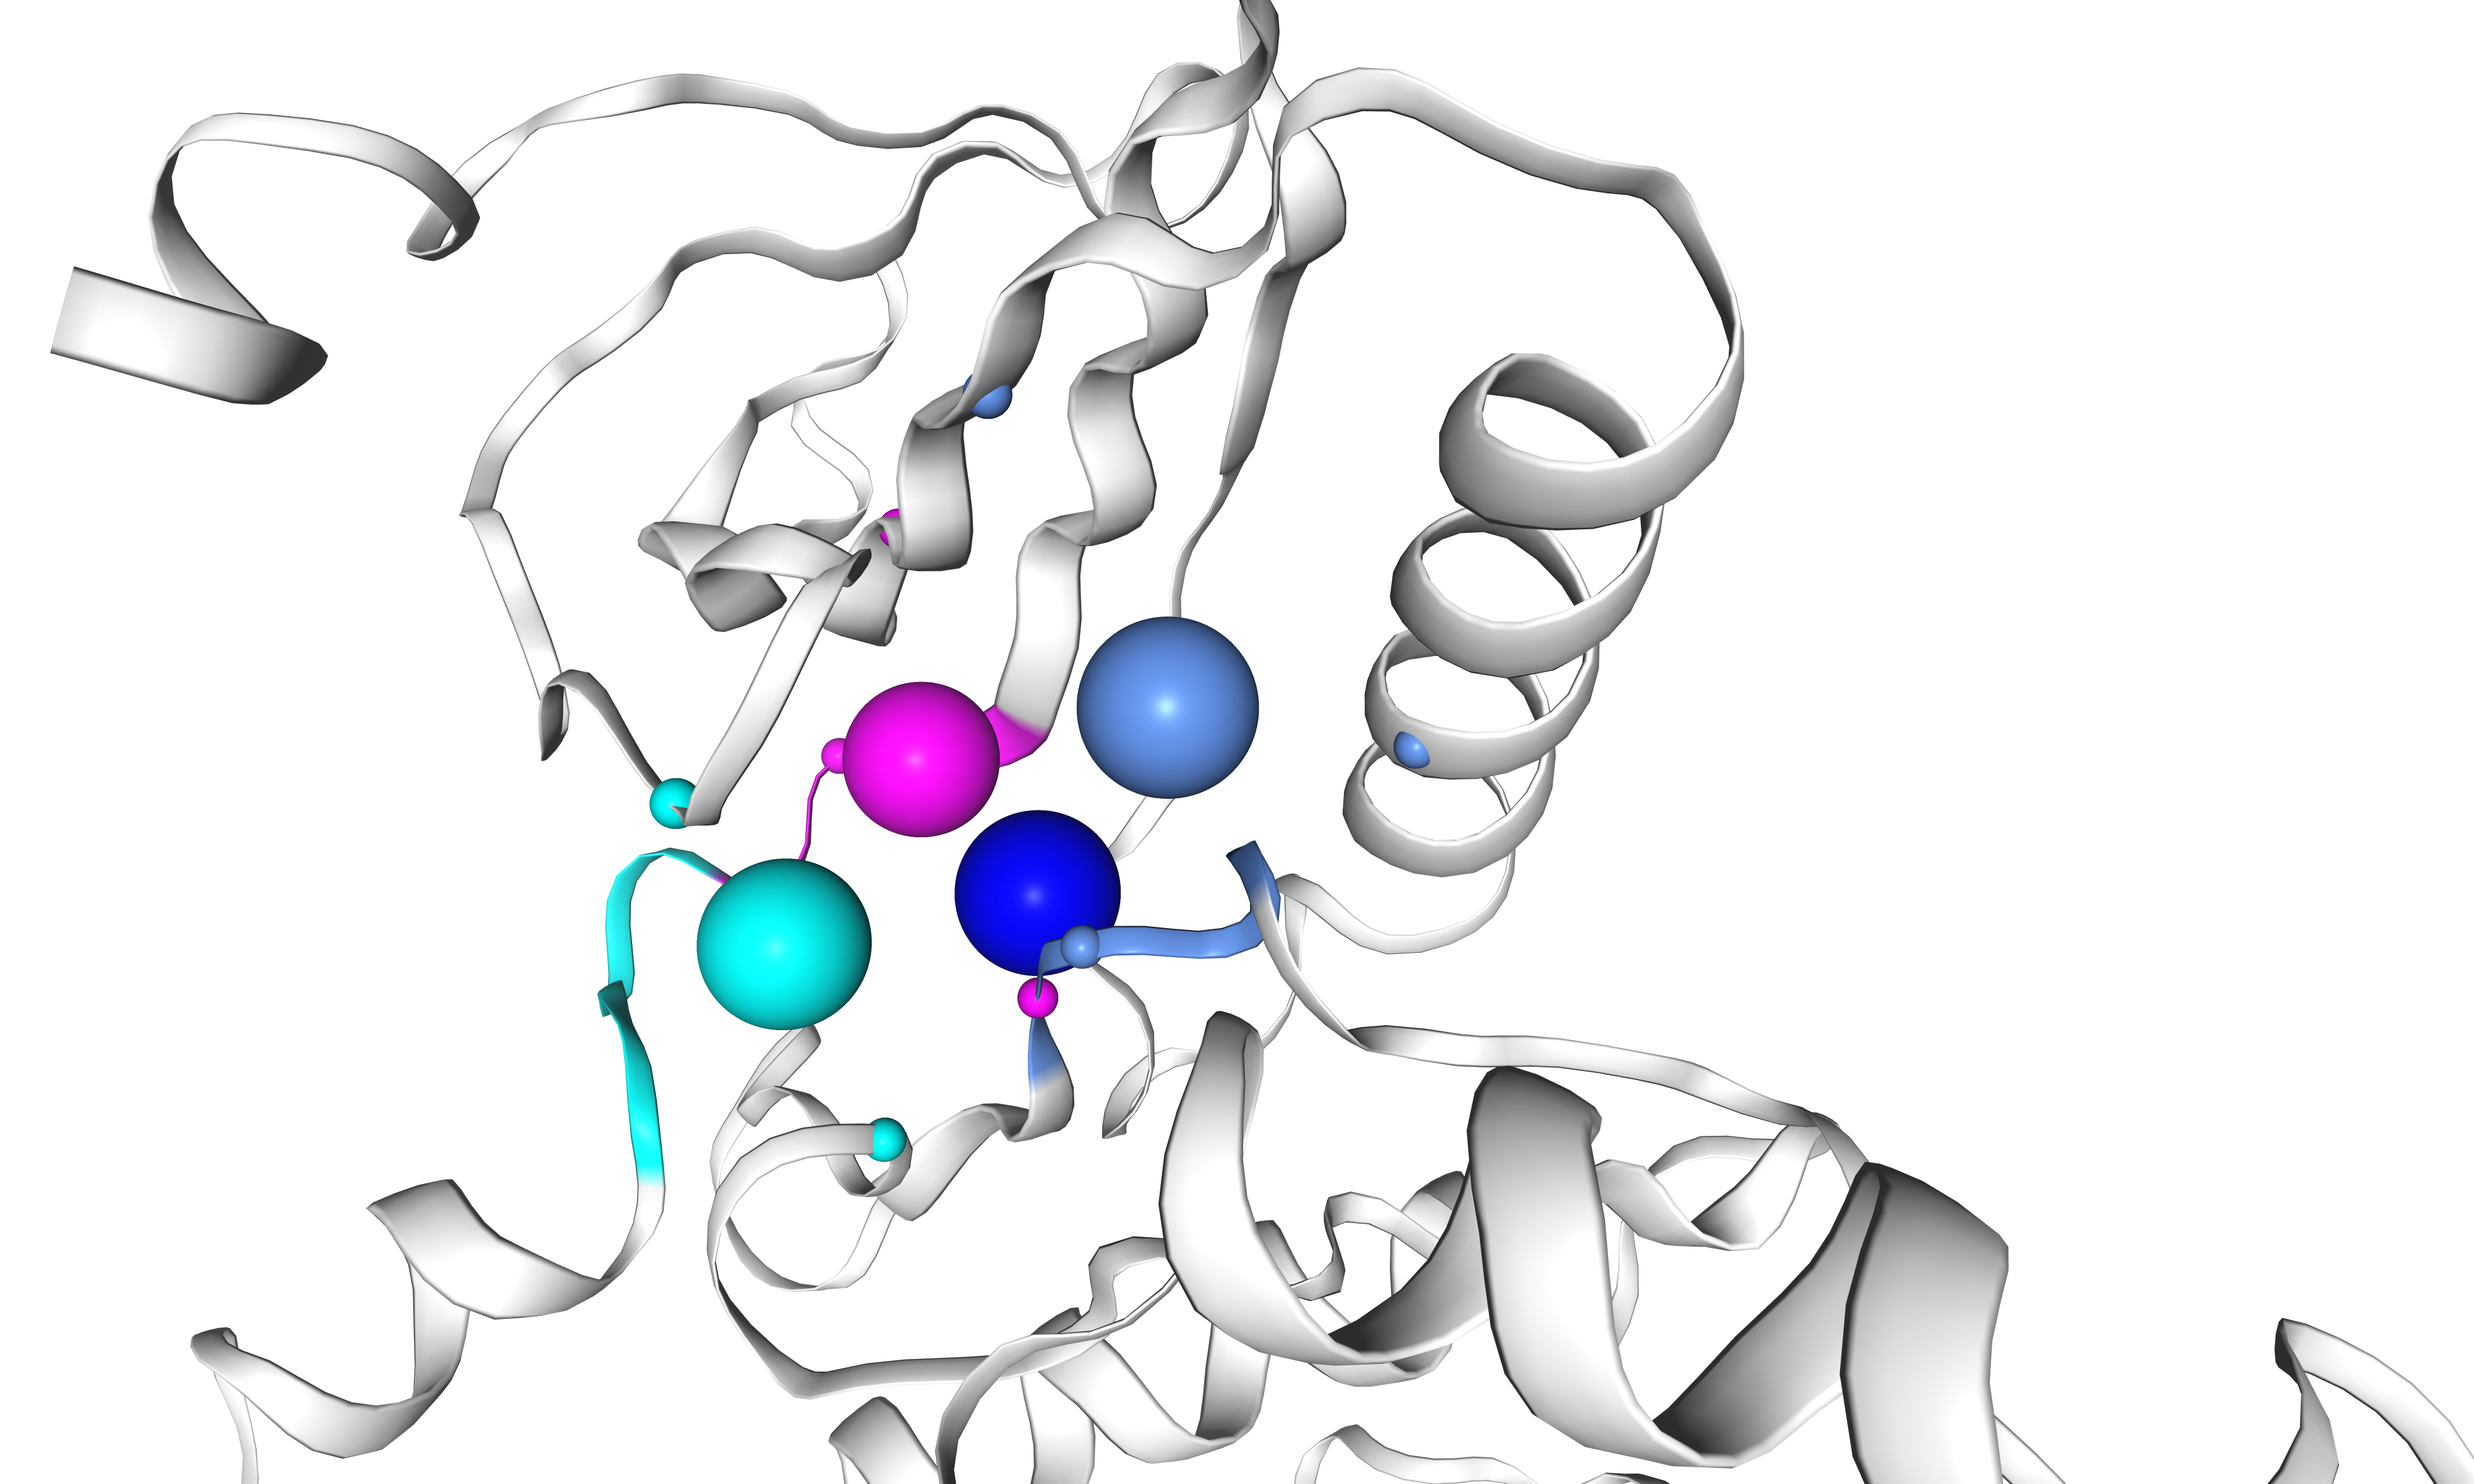

In [26]:
# Static output
view._display_image()

### Advanced: Add all KLIFS-defined regions

Remove all regions that we have defined before.

In [27]:
pocket.clear_regions()

In [28]:
# Regions are cleared
pocket.regions

Define KLIFS region colors (following the same color scheme as shown on the KLIFS website).

In [29]:
KLIFS_REGION_COLORS = {
    "I": "khaki",
    "g.l": "green",
    "II": "khaki",
    "III": "khaki",
    "αC": "red",
    "b.l": "green",
    "IV": "khaki",
    "V": "khaki",
    "GK": "orange",
    "hinge": "magenta",
    "linker": "cyan",
    "αD": "red",
    "αE": "red",
    "VI": "khaki",
    "c.l": "darkorange",
    "VII": "khaki",
    "VIII": "khaki",
    "xDFG": "cornflowerblue",
    "a.l": "cornflowerblue"
}

Define a `DataFrame` that maps the region PDB IDs to the KLIFS-defined colors and labels.

In [30]:
pocket_residues = pocket_residues.rename(
    columns={
        "index": "residue.klifs_id", 
        "Xray_position": "residue.pdb_id", 
        "KLIFS_position": "residue.klifs_region_id"
    }
)
pocket_residues["residue.klifs_region"] = pocket_residues["residue.klifs_region_id"].apply(
    lambda x: ".".join(x.split(".")[:-1])
)
pocket_residues["residue.color"] = pocket_residues["residue.klifs_region"].apply(
    lambda x: KLIFS_REGION_COLORS[x]
)
pocket_residues.head()

residue.klifs_id residue.pdb_id residue.klifs_region_id  \
0                 1             50                     I.1   
1                 2             51                     I.2   
2                 3             52                     I.3   
3                 4             53                   g.l.4   
4                 5             54                   g.l.5   

  residue.klifs_region residue.color  
0                    I         khaki  
1                    I         khaki  
2                    I         khaki  
3                  g.l         green  
4                  g.l         green

In [31]:
pocket_residue_pdb_ids = pocket_residues["residue.pdb_id"].to_list()
pocket_residue_labels = pocket_residues["residue.klifs_region_id"].to_list()

In [32]:
for (region, color), group in pocket_residues.groupby(["residue.klifs_region", "residue.color"]):
    pocket.add_region(region, color, group["residue.pdb_id"].to_list(), group["residue.klifs_region_id"].to_list())

In [33]:
pocket.regions.head()

region.name region.color_name  \
0          GK            orange   
0           I             khaki   
1           I             khaki   
2           I             khaki   
0          II             khaki   

                                    region.color_rgb residue.pdb_id  \
0                     (1.0, 0.6470588235294118, 0.0)            126   
0  (0.9411764705882353, 0.9019607843137255, 0.549...             50   
1  (0.9411764705882353, 0.9019607843137255, 0.549...             51   
2  (0.9411764705882353, 0.9019607843137255, 0.549...             52   
0  (0.9411764705882353, 0.9019607843137255, 0.549...             59   

  residue.label  
0         GK.45  
0           I.1  
1           I.2  
2           I.3  
0         II.10

### Visualize pocket with all KLIFS-defined regions

In [34]:
view = pocket.visualize("protein.mol2")
view

NGLWidget()

In [35]:
time.sleep(5)

In [36]:
view.render_image(),

(Image(value=b'', width='99%'),)

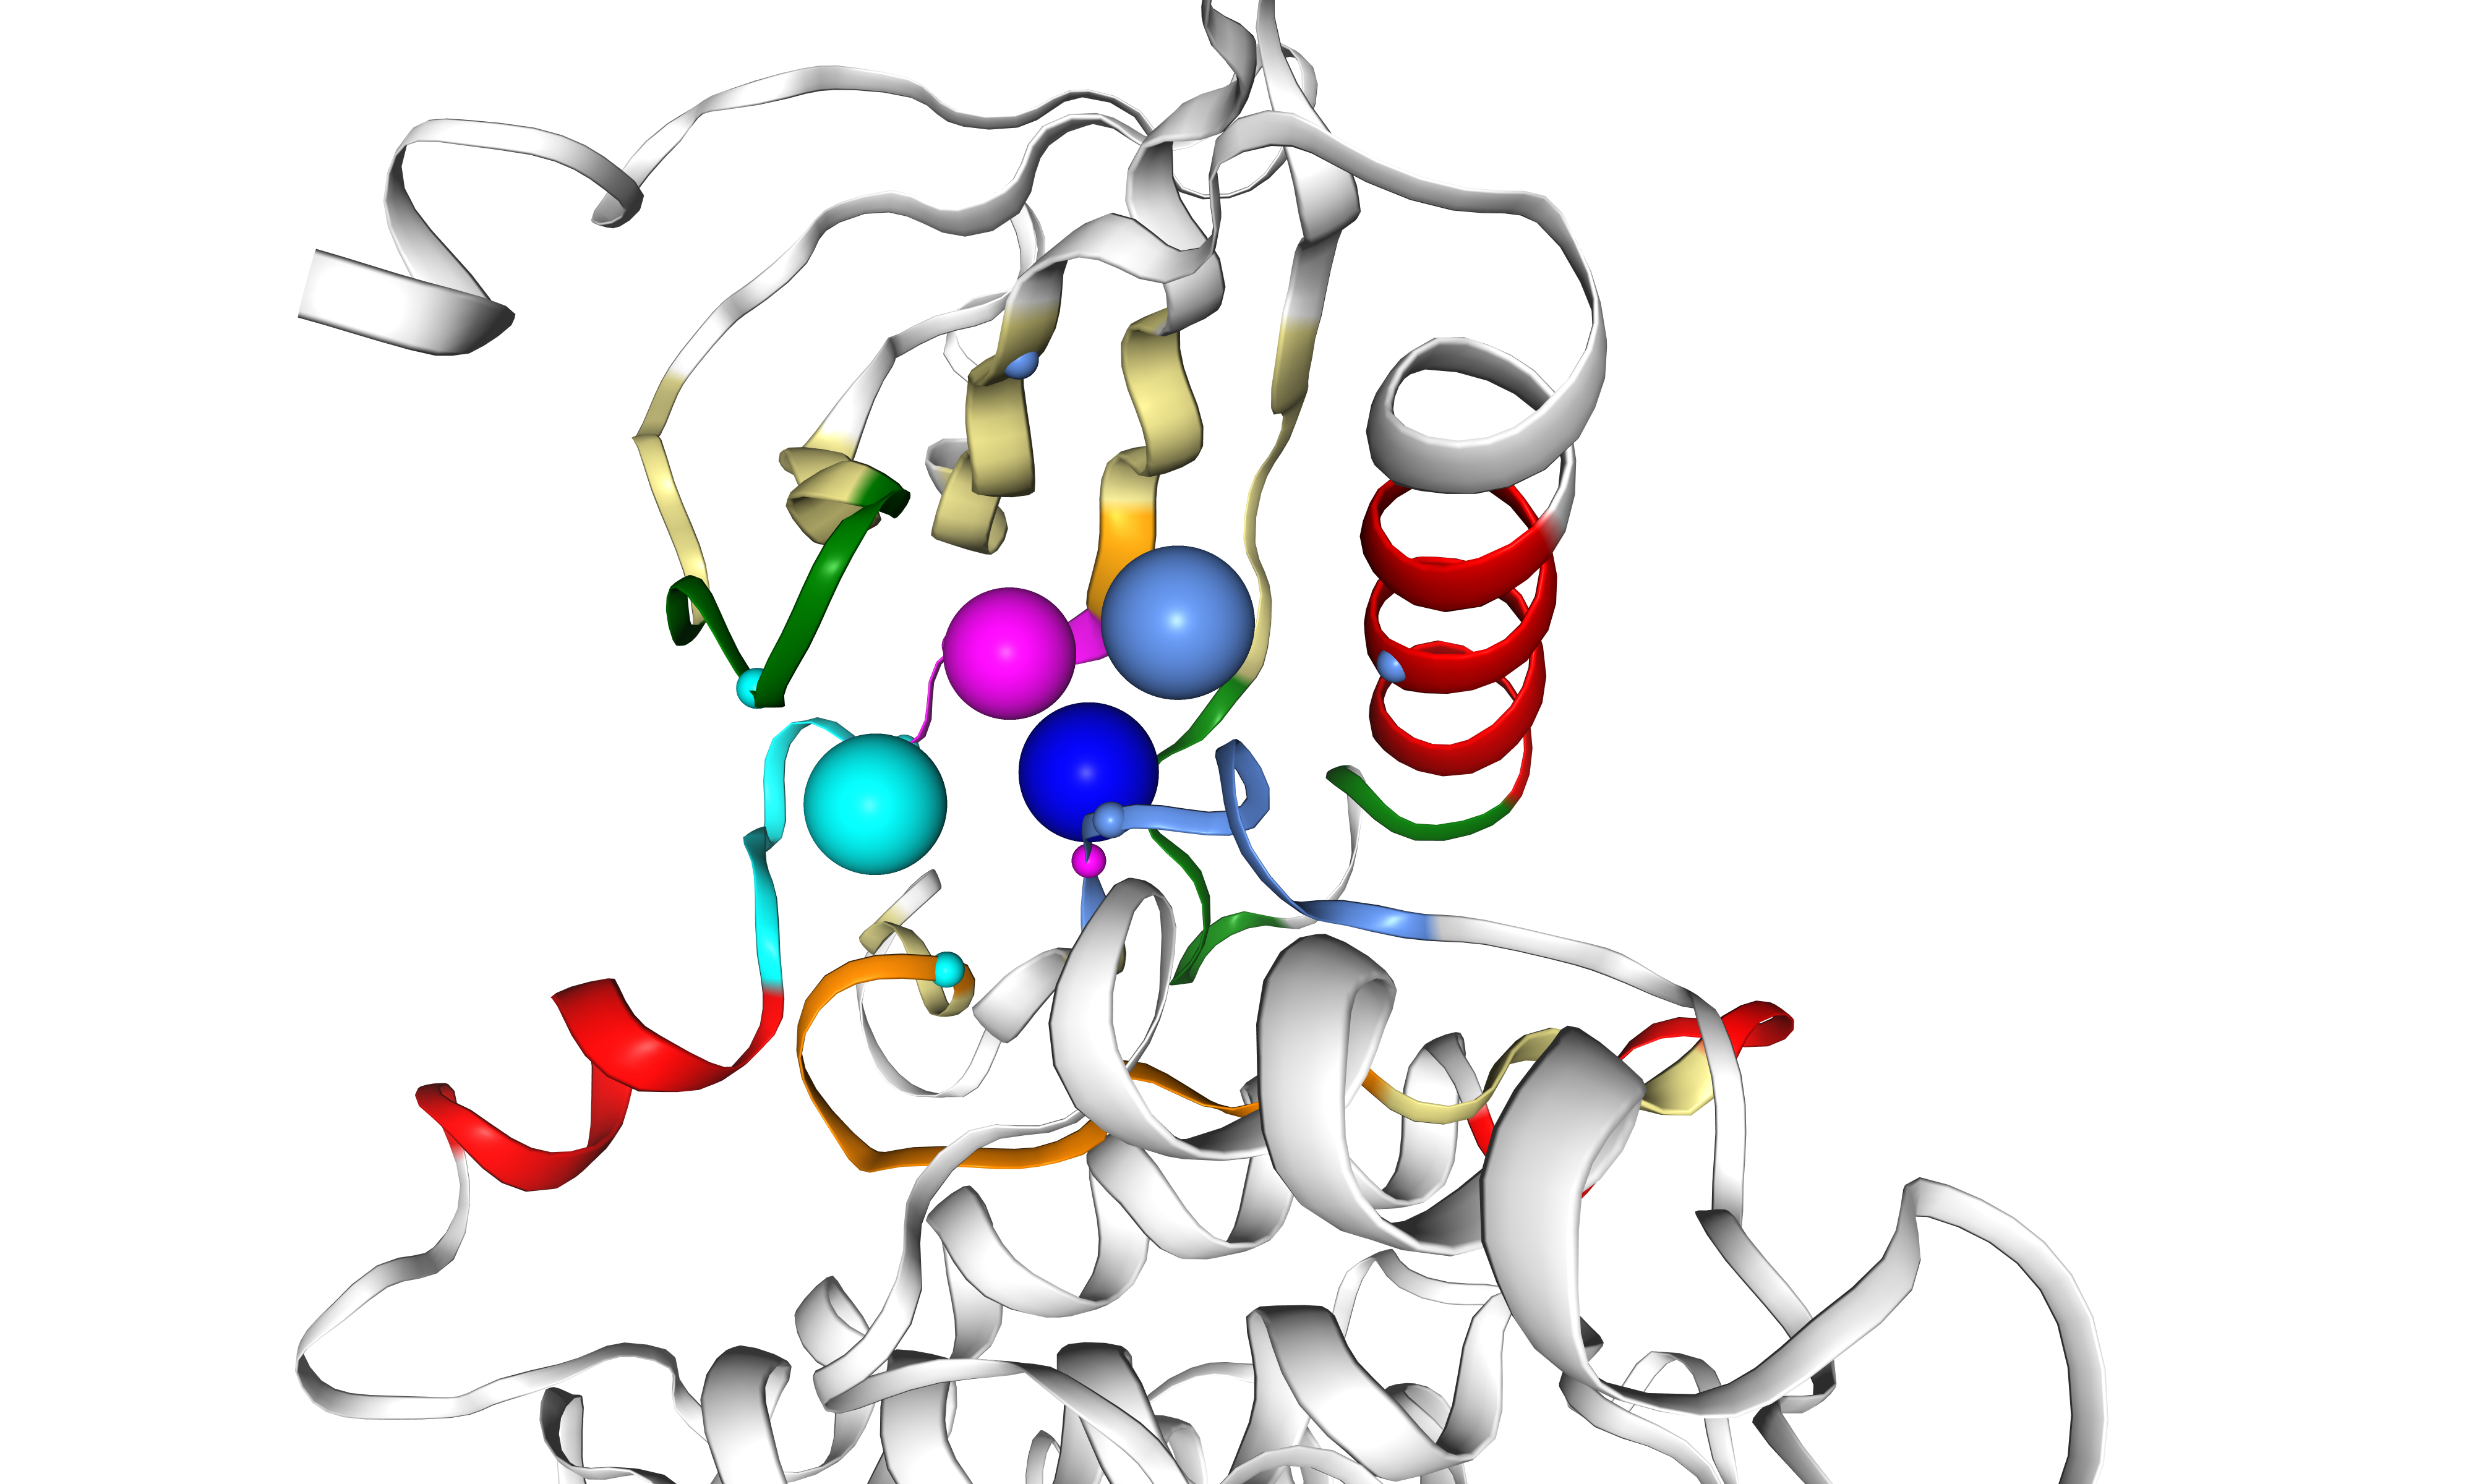

In [37]:
# Static output
view._display_image()

## Anchor residue (`AnchorResidue` class)

Subpockets are calculated based on so class anchor residues, defined each in an `AnchorResidue` class. Subpocket centers are the centroids of all anchor residues' centers (i.e. normally the CA atoms).

- If the anchor residue's CA atom is available in the input structure is available, its coordinates are defined as the anchor residues center (__case 1__).
- If the anchor residue's CA atom is missing in a structure, alternative anchors are chosen if possible: If the residue CA atoms before and after the input anchor residue are available, their CA atoms' centroid is chosen (__case 2__). 
- If only one of the neighboring residues' CA atoms is available, that single CA atoms is chosen (__case 3 and 4__).
- If none of the anchor residue's and neighboring residues' CA atoms is available, no anchor residue center is defined (__case 5__).

The determination of anchor residues depends on the CA atom availablity of the user-defined anchor residue as well as the residue before and after.

### Test behaviour for missing anchor residue

In [39]:
dataframe = pd.DataFrame(
    {"residue.pdb_id": ["1", "2", "3", "7", "8", "9", "11"],
     "atom.name": ["CA", "CA", "CA", "CA", "CA", "CA", "CA"],
     "atom.x": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.y": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0],
     "atom.z": [1.0, 2.0, 3.0, 4.0, 20.0, 30.0, 40.0]
    }
)
dataframe

residue.pdb_id atom.name  atom.x  atom.y  atom.z
0              1        CA     1.0     1.0     1.0
1              2        CA     2.0     2.0     2.0
2              3        CA     3.0     3.0     3.0
3              7        CA     4.0     4.0     4.0
4              8        CA    20.0    20.0    20.0
5              9        CA    30.0    30.0    30.0
6             11        CA    40.0    40.0    40.0

In [40]:
def test_anchor_residue_behaviour(dataframe, residue_pdb_id):
    residue = AnchorResidue()
    residue.from_dataframe(dataframe, residue_pdb_id)
    print("Input residue:       ", residue.pdb_id)
    print("Alternative residue: ", residue.pdb_id_alternative)
    print("Residue center:      ", residue.center)

#### Case 1: Anchor residue available

In [41]:
test_anchor_residue_behaviour(dataframe, "1")

Input residue:        1
Alternative residue:  None
Residue center:       [1. 1. 1.]


#### Case 2: Anchor residue not available, but residues before and after

In [42]:
test_anchor_residue_behaviour(dataframe, "10")

Input residue:        10
Alternative residue:  ['9', '11']
Residue center:       [35. 35. 35.]


#### Case 3: Anchor residue not available, but residues before (not after)

In [43]:
test_anchor_residue_behaviour(dataframe, "4")

Input residue:        4
Alternative residue:  ['3']
Residue center:       [3. 3. 3.]


#### Case 4: Anchor residue not available, but residues after (not before)

In [44]:
test_anchor_residue_behaviour(dataframe, "6")

Input residue:        6
Alternative residue:  ['7']
Residue center:       [4. 4. 4.]


#### Case 5: Anchor residue and residues before and after not available

In [45]:
test_anchor_residue_behaviour(dataframe, "5")

Input residue:        5
Alternative residue:  None
Residue center:       None


## Delete temporary files

In [47]:
Path("protein.mol2").unlink()